# 03 - Régression Multi-Sorties avec TensorFlow

**Objectif du notebook :**
- Implémentation d'un réseau de neurones (DNN) pour la régression multi-sorties
- Prédiction simultanée de 4 variables continues :
  - Project_Grade (0-100)
  - Quiz_Score_Avg (0-100)
  - Progress_Percentage (0-100)
  - Satisfaction_Rating (1-5)

**Architecture :**
- Réseau dense (MLP/DNN) avec couches cachées
- Optimisation des hyperparamètres
- Callbacks : EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
- Évaluation avec métriques : MSE, MAE, R²

---

## 1. Imports et Configuration

In [1]:
"""Importation des bibliothèques nécessaires."""

# Data manipulation
import numpy as np
import pandas as pd
import pickle

# TensorFlow et Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks, regularizers
from tensorflow.keras.optimizers import Adam

# Métriques et évaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Utilities
import warnings
import os
from datetime import datetime

warnings.filterwarnings('ignore')

# Configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Seed pour la reproductibilité
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

# Configuration GPU
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    print(f"✓ GPU disponible : {physical_devices[0].name}")
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    print("⚠️  Aucun GPU détecté, utilisation du CPU")

print(f"✓ TensorFlow version : {tf.__version__}")
print(f"✓ Keras version : {keras.__version__}")
print(f"✓ Random state : {RANDOM_STATE}")

⚠️  Aucun GPU détecté, utilisation du CPU
✓ TensorFlow version : 2.20.0
✓ Keras version : 3.11.3
✓ Random state : 42


## 2. Chargement des Données Prétraitées

In [2]:
"""Chargement des données prétraitées."""

print("="*70)
print(" CHARGEMENT DES DONNÉES")
print("="*70)

data_dir = 'tensorflow_preprocessed_data'

# Chargement des données
X_train = np.load(f'{data_dir}/X_train.npy')
y_reg_train = np.load(f'{data_dir}/y_reg_train.npy')

X_val = np.load(f'{data_dir}/X_val.npy')
y_reg_val = np.load(f'{data_dir}/y_reg_val.npy')

X_test = np.load(f'{data_dir}/X_test.npy')
y_reg_test = np.load(f'{data_dir}/y_reg_test.npy')

# Chargement de la configuration
with open(f'{data_dir}/config.pkl', 'rb') as f:
    config = pickle.load(f)

# Chargement des noms de features
with open(f'{data_dir}/feature_names.pkl', 'rb') as f:
    feature_names = pickle.load(f)

print("\nDonnées chargées :")
print(f"  X_train      : {X_train.shape}")
print(f"  y_reg_train  : {y_reg_train.shape}")
print(f"  X_val        : {X_val.shape}")
print(f"  y_reg_val    : {y_reg_val.shape}")
print(f"  X_test       : {X_test.shape}")
print(f"  y_reg_test   : {y_reg_test.shape}")

print(f"\n✓ {config['n_features']} features chargées")
print(f"✓ {config['n_regression_targets']} cibles de régression")
print(f"\nCibles : {', '.join(config['regression_targets'])}")

 CHARGEMENT DES DONNÉES

Données chargées :
  X_train      : (70000, 71)
  y_reg_train  : (70000, 4)
  X_val        : (15000, 71)
  y_reg_val    : (15000, 4)
  X_test       : (15000, 71)
  y_reg_test   : (15000, 4)

✓ 71 features chargées
✓ 4 cibles de régression

Cibles : Project_Grade, Quiz_Score_Avg, Progress_Percentage, Satisfaction_Rating


## 3. Exploration des Cibles de Régression

 STATISTIQUES DES CIBLES

Statistiques descriptives (Training set) :
       Project_Grade  Quiz_Score_Avg  Progress_Percentage  Satisfaction_Rating
count   70000.000000    70000.000000         70000.000000         70000.000000
mean       68.156069       73.209261            53.784933             4.131909
std        15.322750       12.541730            12.509653             0.700600
min         5.500000       19.800000             7.600000             1.000000
25%        57.700000       64.700000            45.300000             3.700000
50%        68.300000       73.300000            53.900000             4.200000
75%        78.800000       81.800000            62.400000             4.700000
max       100.000000      100.000000            98.600000             5.000000


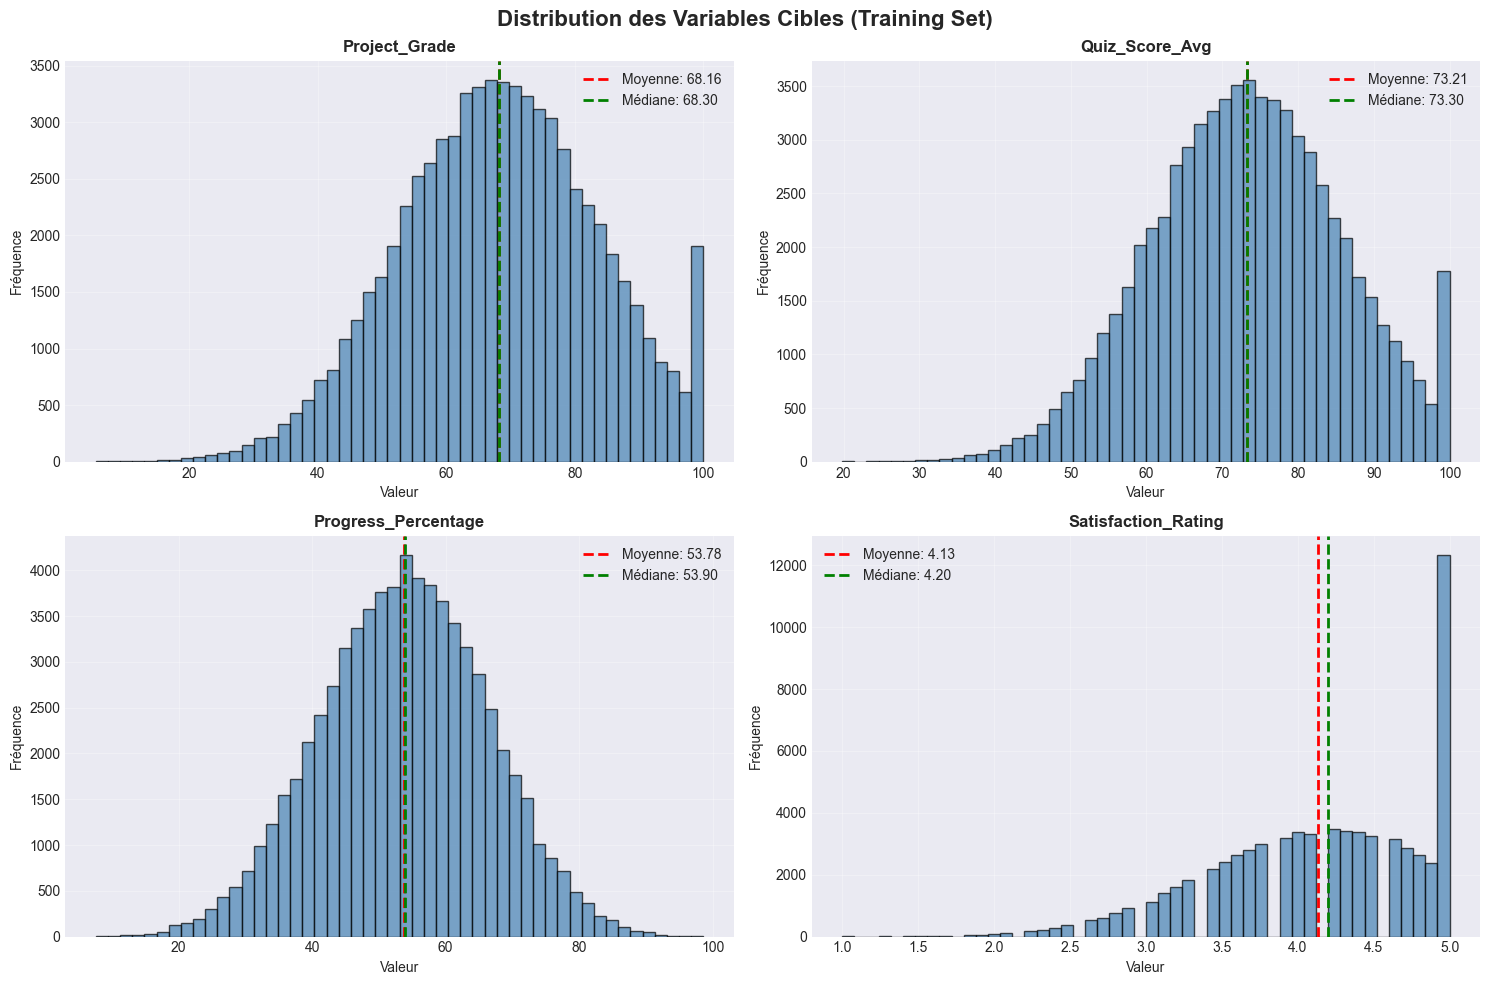


 CORRÉLATIONS ENTRE LES CIBLES

                      Project_Grade  Quiz_Score_Avg  Progress_Percentage  \
Project_Grade             1.000000        0.094381             0.165507   
Quiz_Score_Avg            0.094381        1.000000             0.125193   
Progress_Percentage       0.165507        0.125193             1.000000   
Satisfaction_Rating       0.033961        0.052843             0.056236   

                     Satisfaction_Rating  
Project_Grade                   0.033961  
Quiz_Score_Avg                  0.052843  
Progress_Percentage             0.056236  
Satisfaction_Rating             1.000000  


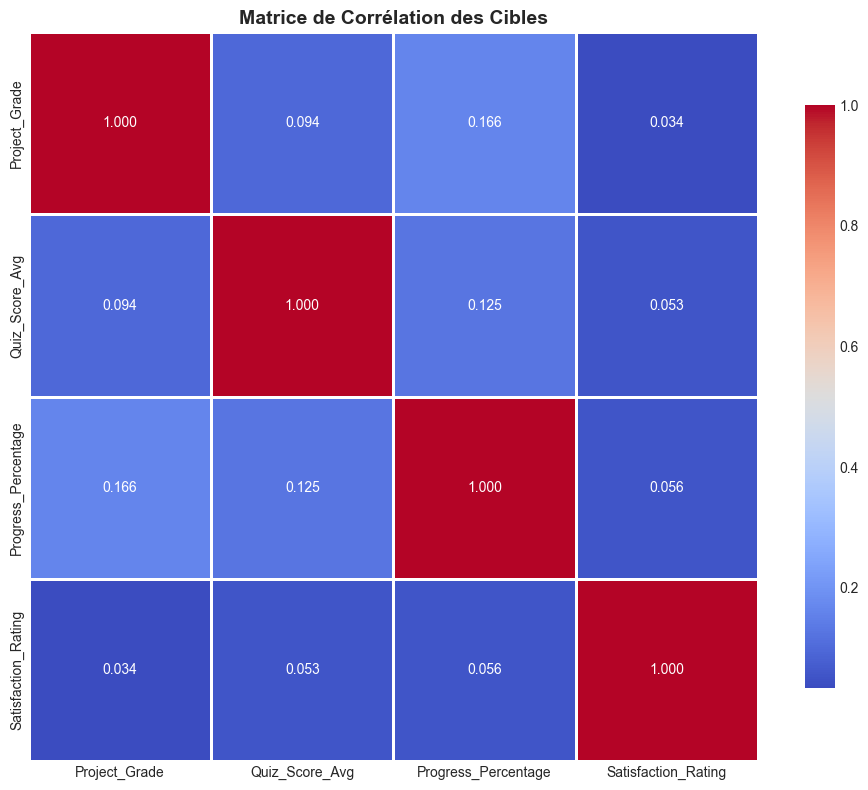

In [3]:
"""Analyse des distributions des cibles."""

print("="*70)
print(" STATISTIQUES DES CIBLES")
print("="*70)

target_names = config['regression_targets']
y_train_df = pd.DataFrame(y_reg_train, columns=target_names)

print("\nStatistiques descriptives (Training set) :")
print(y_train_df.describe())

# Visualisation des distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Distribution des Variables Cibles (Training Set)', fontsize=16, fontweight='bold')

for idx, target in enumerate(target_names):
    ax = axes[idx // 2, idx % 2]
    
    # Histogramme
    ax.hist(y_reg_train[:, idx], bins=50, alpha=0.7, edgecolor='black', color='steelblue')
    ax.set_title(f'{target}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Valeur')
    ax.set_ylabel('Fréquence')
    ax.grid(True, alpha=0.3)
    
    # Statistiques
    mean_val = y_reg_train[:, idx].mean()
    median_val = np.median(y_reg_train[:, idx])
    ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Moyenne: {mean_val:.2f}')
    ax.axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Médiane: {median_val:.2f}')
    ax.legend()

plt.tight_layout()
plt.show()

# Matrice de corrélation entre les cibles
print("\n" + "="*70)
print(" CORRÉLATIONS ENTRE LES CIBLES")
print("="*70)

correlation_matrix = y_train_df.corr()
print("\n", correlation_matrix)

# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm', 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Matrice de Corrélation des Cibles', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 4. Construction du Modèle de Régression Multi-Sorties

In [4]:
"""Construction de l'architecture du réseau de neurones."""

def build_regression_model(input_dim, n_outputs, 
                          hidden_layers=[256, 128, 64],
                          dropout_rate=0.3,
                          l2_reg=0.001,
                          learning_rate=0.001):
    """
    Construction d'un modèle DNN pour la régression multi-sorties.
    
    Architecture :
    - Couches d'entrée avec normalisation batch
    - Couches cachées denses avec régularisation L2
    - Dropout pour la régularisation
    - Couche de sortie linéaire pour chaque cible
    
    Args:
        input_dim: Nombre de features d'entrée
        n_outputs: Nombre de sorties (cibles de régression)
        hidden_layers: Liste des tailles de couches cachées
        dropout_rate: Taux de dropout
        l2_reg: Coefficient de régularisation L2
        learning_rate: Taux d'apprentissage
    
    Returns:
        Modèle Keras compilé
    """
    
    # Input layer
    inputs = keras.Input(shape=(input_dim,), name='input_features')
    
    # Première couche avec normalisation batch
    x = layers.Dense(
        hidden_layers[0],
        activation='relu',
        kernel_regularizer=regularizers.l2(l2_reg),
        kernel_initializer='he_normal',
        name='dense_1'
    )(inputs)
    x = layers.BatchNormalization(name='batch_norm_1')(x)
    x = layers.Dropout(dropout_rate, name='dropout_1')(x)
    
    # Couches cachées supplémentaires
    for i, units in enumerate(hidden_layers[1:], start=2):
        x = layers.Dense(
            units,
            activation='relu',
            kernel_regularizer=regularizers.l2(l2_reg),
            kernel_initializer='he_normal',
            name=f'dense_{i}'
        )(x)
        x = layers.BatchNormalization(name=f'batch_norm_{i}')(x)
        x = layers.Dropout(dropout_rate, name=f'dropout_{i}')(x)
    
    # Couche de sortie (linéaire pour la régression)
    outputs = layers.Dense(
        n_outputs,
        activation='linear',
        name='regression_output'
    )(x)
    
    # Création du modèle
    model = keras.Model(inputs=inputs, outputs=outputs, name='Regression_DNN')
    
    # Compilation
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='mse',  # Mean Squared Error pour la régression
        metrics=['mae', 'mse']  # Mean Absolute Error et MSE
    )
    
    return model

print("✓ Fonction de construction du modèle définie")

✓ Fonction de construction du modèle définie


In [5]:
"""Instanciation et affichage du modèle."""

print("="*70)
print(" CONSTRUCTION DU MODÈLE")
print("="*70)

# Hyperparamètres
HYPERPARAMS = {
    'hidden_layers': [256, 128, 64, 32],  # 4 couches cachées
    'dropout_rate': 0.3,
    'l2_reg': 0.001,
    'learning_rate': 0.001
}

# Construction du modèle
model_regression = build_regression_model(
    input_dim=X_train.shape[1],
    n_outputs=y_reg_train.shape[1],
    **HYPERPARAMS
)

# Affichage de l'architecture
print("\nArchitecture du modèle :")
model_regression.summary()

# Visualisation de l'architecture
keras.utils.plot_model(
    model_regression,
    to_file='tensorflow_regression_model.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=True,
    dpi=96
)
print("\n✓ Diagramme du modèle sauvegardé : tensorflow_regression_model.png")

 CONSTRUCTION DU MODÈLE

Architecture du modèle :


Model: "Regression_DNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_features (InputLayer)     │ (None, 71)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_1                    │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_2                    │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_3                    │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_4                    │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ regression_output (Dense)       │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,716 (248.89 KB)

 Trainable params: 62,756 (245.14 KB)

 Non-trainable params: 960 (3.75 KB)

You must install pydot (`pip install pydot`) for `plot_model` to work.

✓ Diagramme du modèle sauvegardé : tensorflow_regression_model.png


## 5. Configuration des Callbacks

In [6]:
"""Configuration des callbacks pour l'entraînement."""

print("="*70)
print(" CONFIGURATION DES CALLBACKS")
print("="*70)

# Création du dossier pour les sauvegardes
model_dir = 'tensorflow_regression_models'
os.makedirs(model_dir, exist_ok=True)

# 1. EarlyStopping - Arrêt précoce si pas d'amélioration
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1,
    mode='min'
)
print("✓ EarlyStopping configuré (patience=20)")

# 2. ReduceLROnPlateau - Réduction du learning rate
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=1e-7,
    verbose=1,
    mode='min'
)
print("✓ ReduceLROnPlateau configuré (factor=0.5, patience=10)")

# 3. ModelCheckpoint - Sauvegarde du meilleur modèle
checkpoint = callbacks.ModelCheckpoint(
    filepath=f'{model_dir}/best_regression_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1,
    mode='min'
)
print("✓ ModelCheckpoint configuré")

# 4. TensorBoard - Visualisation de l'entraînement
log_dir = f'tensorflow_logs/regression_{datetime.now().strftime("%Y%m%d-%H%M%S")}'
tensorboard = callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,
    write_graph=True
)
print(f"✓ TensorBoard configuré (log_dir={log_dir})")

# 5. CSVLogger - Sauvegarde de l'historique
csv_logger = callbacks.CSVLogger(
    f'{model_dir}/training_history.csv',
    append=False
)
print("✓ CSVLogger configuré")

# Liste de tous les callbacks
callback_list = [
    early_stopping,
    reduce_lr,
    checkpoint,
    tensorboard,
    csv_logger
]

print(f"\n✓ {len(callback_list)} callbacks configurés")

 CONFIGURATION DES CALLBACKS
✓ EarlyStopping configuré (patience=20)
✓ ReduceLROnPlateau configuré (factor=0.5, patience=10)
✓ ModelCheckpoint configuré
✓ TensorBoard configuré (log_dir=tensorflow_logs/regression_20251215-230948)
✓ CSVLogger configuré

✓ 5 callbacks configurés


## 6. Entraînement du Modèle

In [7]:
"""Entraînement du modèle de régression."""

print("="*70)
print(" ENTRAÎNEMENT DU MODÈLE")
print("="*70)

# Hyperparamètres d'entraînement
EPOCHS = 200
BATCH_SIZE = 64

print(f"\nConfiguration :")
print(f"  Epochs       : {EPOCHS}")
print(f"  Batch size   : {BATCH_SIZE}")
print(f"  Train samples: {len(X_train):,}")
print(f"  Val samples  : {len(X_val):,}")
print(f"\nDébut de l'entraînement...\n")

# Entraînement
history = model_regression.fit(
    X_train, y_reg_train,
    validation_data=(X_val, y_reg_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callback_list,
    verbose=1
)

print("\n" + "="*70)
print(" ENTRAÎNEMENT TERMINÉ")
print("="*70)
print(f"✓ Nombre d'epochs effectués : {len(history.history['loss'])}")

 ENTRAÎNEMENT DU MODÈLE

Configuration :
  Epochs       : 200
  Batch size   : 64
  Train samples: 70,000
  Val samples  : 15,000

Début de l'entraînement...

Epoch 1/200
1088/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2710.1047 - mae: 43.4516 - mse: 2709.1279
Epoch 1: val_loss improved from None to 204.80814, saving model to tensorflow_regression_models/best_regression_model.keras
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 1779.4669 - mae: 32.6912 - mse: 1778.4689 - val_loss: 204.8081 - val_mae: 9.5791 - val_mse: 203.7804 - learning_rate: 0.0010
Epoch 2/200
1086/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 188.1815 - mae: 9.2855 - mse: 187.1504
Epoch 2: val_loss improved from 204.80814 to 96.21082, saving model to tensorflow_regression_models/best_regression_model.keras
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 167.4502 - mae: 8.7626 - mse: 166.4162 - val_loss: 96.2108 - val_mae: 6.3027 - val_mse: 95.1723 - learning_rate: 0.0010
Epoch 3/200
1088/1094 ━━━━━━━━━━━━━

## 7. Visualisation de l'Entraînement

 ANALYSE DE L'ENTRAÎNEMENT


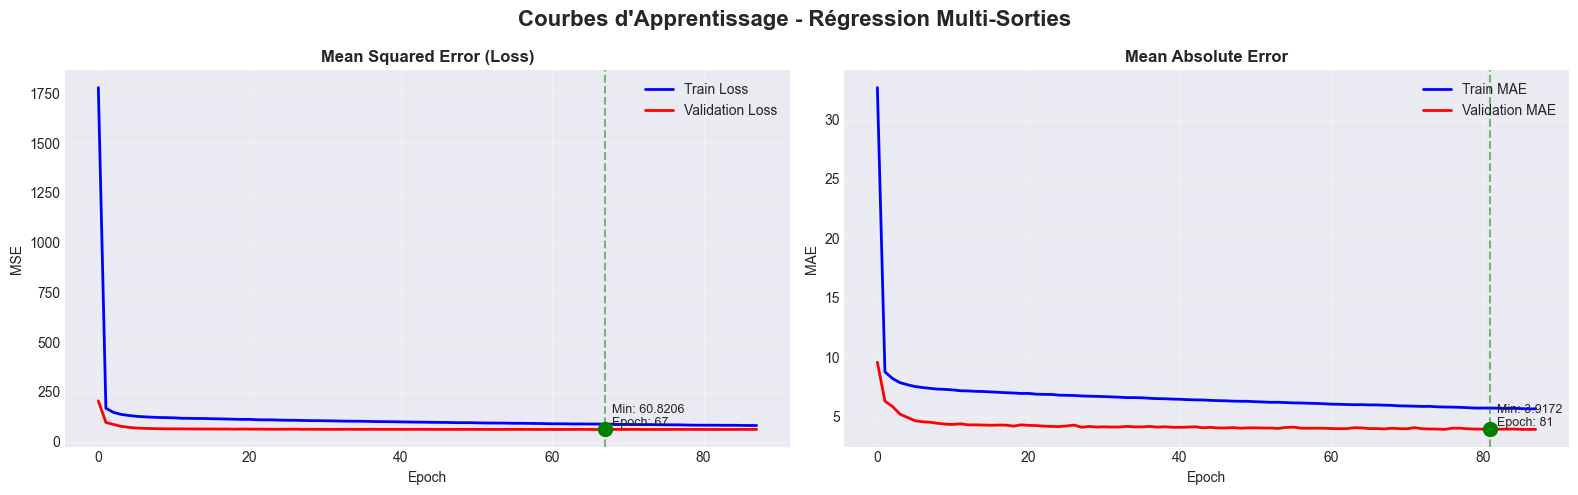


Meilleures performances :
  Validation Loss (MSE) : 60.8206 (epoch 67)
  Validation MAE        : 3.9172 (epoch 81)

✓ Courbes sauvegardées : tensorflow_regression_models/training_curves.png


In [8]:
"""Visualisation des courbes d'apprentissage."""

print("="*70)
print(" ANALYSE DE L'ENTRAÎNEMENT")
print("="*70)

# Création du graphique
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
fig.suptitle('Courbes d\'Apprentissage - Régression Multi-Sorties', fontsize=16, fontweight='bold')

# 1. Loss (MSE)
ax1 = axes[0]
ax1.plot(history.history['loss'], label='Train Loss', linewidth=2, color='blue')
ax1.plot(history.history['val_loss'], label='Validation Loss', linewidth=2, color='red')
ax1.set_title('Mean Squared Error (Loss)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('MSE')
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

# Annotation du minimum
min_val_loss = min(history.history['val_loss'])
min_epoch = history.history['val_loss'].index(min_val_loss)
ax1.axvline(min_epoch, color='green', linestyle='--', alpha=0.5)
ax1.plot(min_epoch, min_val_loss, 'go', markersize=10)
ax1.text(min_epoch, min_val_loss, 
         f'  Min: {min_val_loss:.4f}\n  Epoch: {min_epoch}',
         fontsize=9, verticalalignment='bottom')

# 2. MAE
ax2 = axes[1]
ax2.plot(history.history['mae'], label='Train MAE', linewidth=2, color='blue')
ax2.plot(history.history['val_mae'], label='Validation MAE', linewidth=2, color='red')
ax2.set_title('Mean Absolute Error', fontsize=12, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('MAE')
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

# Annotation du minimum
min_val_mae = min(history.history['val_mae'])
min_mae_epoch = history.history['val_mae'].index(min_val_mae)
ax2.axvline(min_mae_epoch, color='green', linestyle='--', alpha=0.5)
ax2.plot(min_mae_epoch, min_val_mae, 'go', markersize=10)
ax2.text(min_mae_epoch, min_val_mae,
         f'  Min: {min_val_mae:.4f}\n  Epoch: {min_mae_epoch}',
         fontsize=9, verticalalignment='bottom')

plt.tight_layout()
plt.savefig(f'{model_dir}/training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nMeilleures performances :")
print(f"  Validation Loss (MSE) : {min_val_loss:.4f} (epoch {min_epoch})")
print(f"  Validation MAE        : {min_val_mae:.4f} (epoch {min_mae_epoch})")
print(f"\n✓ Courbes sauvegardées : {model_dir}/training_curves.png")

## 8. Évaluation sur l'Ensemble de Test

In [9]:
"""Évaluation complète du modèle sur l'ensemble de test."""

print("="*70)
print(" ÉVALUATION SUR L'ENSEMBLE DE TEST")
print("="*70)

# Prédictions
y_pred_test = model_regression.predict(X_test, verbose=0)

# Calcul des métriques pour chaque cible
target_names = config['regression_targets']

results = []
for i, target in enumerate(target_names):
    y_true = y_reg_test[:, i]
    y_pred = y_pred_test[:, i]
    
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    results.append({
        'Target': target,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2
    })

# Affichage des résultats
results_df = pd.DataFrame(results)
print("\nMétriques par cible :")
print(results_df.to_string(index=False))

# Métriques globales
print("\n" + "="*70)
print(" MÉTRIQUES GLOBALES")
print("="*70)
print(f"  MSE moyen  : {results_df['MSE'].mean():.4f}")
print(f"  RMSE moyen : {results_df['RMSE'].mean():.4f}")
print(f"  MAE moyen  : {results_df['MAE'].mean():.4f}")
print(f"  R² moyen   : {results_df['R²'].mean():.4f}")

# Sauvegarde des résultats
results_df.to_csv(f'{model_dir}/test_results.csv', index=False)
print(f"\n✓ Résultats sauvegardés : {model_dir}/test_results.csv")

 ÉVALUATION SUR L'ENSEMBLE DE TEST

Métriques par cible :
             Target        MSE      RMSE       MAE       R²
      Project_Grade 228.785283 15.125650 12.167724 0.025643
     Quiz_Score_Avg   8.780944  2.963266  1.785532 0.943977
Progress_Percentage   3.239581  1.799884  1.375250 0.979116
Satisfaction_Rating   0.488697  0.699069  0.578424 0.004959

 MÉTRIQUES GLOBALES
  MSE moyen  : 60.3236
  RMSE moyen : 5.1470
  MAE moyen  : 3.9767
  R² moyen   : 0.4884

✓ Résultats sauvegardés : tensorflow_regression_models/test_results.csv


## 9. Visualisation des Prédictions

 VISUALISATION DES PRÉDICTIONS


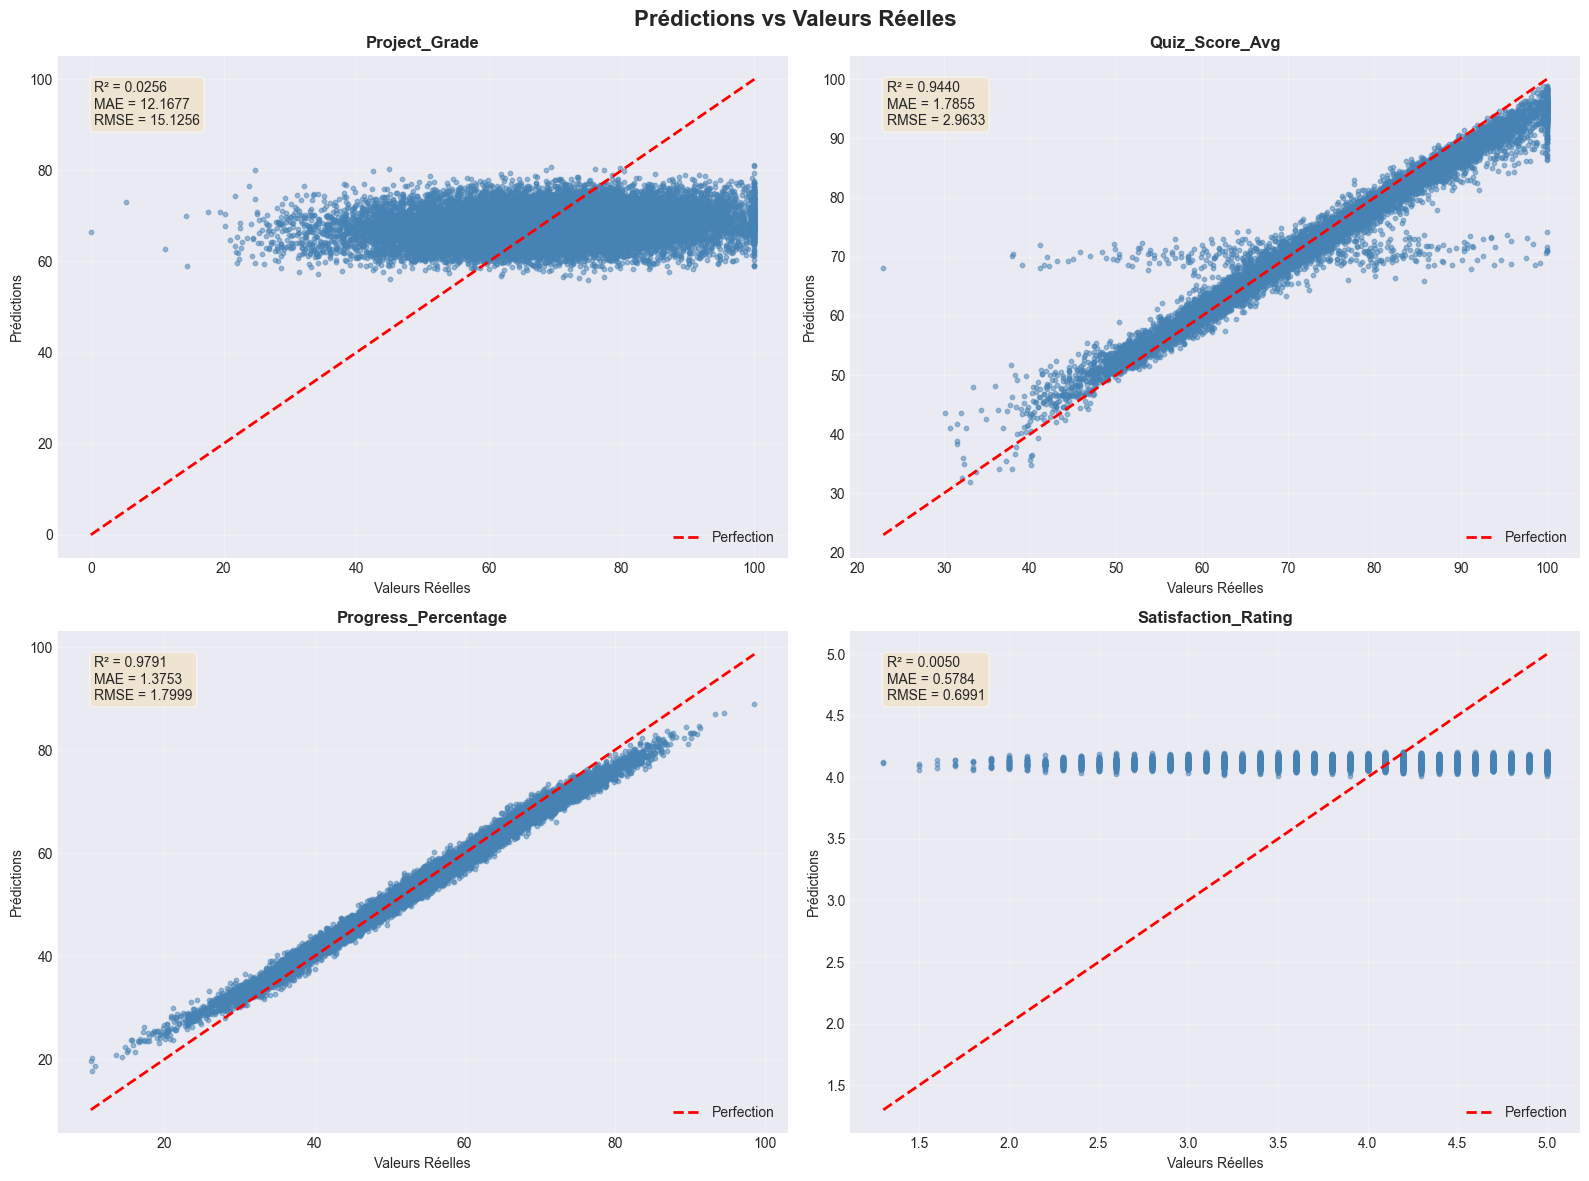

✓ Graphiques sauvegardés : tensorflow_regression_models/predictions_vs_true.png


In [10]:
"""Visualisation des prédictions vs valeurs réelles."""

print("="*70)
print(" VISUALISATION DES PRÉDICTIONS")
print("="*70)

# Graphiques scatter plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Prédictions vs Valeurs Réelles', fontsize=16, fontweight='bold')

for idx, target in enumerate(target_names):
    ax = axes[idx // 2, idx % 2]
    
    y_true = y_reg_test[:, idx]
    y_pred = y_pred_test[:, idx]
    
    # Scatter plot
    ax.scatter(y_true, y_pred, alpha=0.5, s=10, c='steelblue')
    
    # Ligne de perfection
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfection')
    
    # Configuration
    ax.set_title(f'{target}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Valeurs Réelles')
    ax.set_ylabel('Prédictions')
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    # Ajout des métriques sur le graphique
    r2 = results_df[results_df['Target'] == target]['R²'].values[0]
    mae = results_df[results_df['Target'] == target]['MAE'].values[0]
    rmse = results_df[results_df['Target'] == target]['RMSE'].values[0]
    
    textstr = f'R² = {r2:.4f}\nMAE = {mae:.4f}\nRMSE = {rmse:.4f}'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=props)

plt.tight_layout()
plt.savefig(f'{model_dir}/predictions_vs_true.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Graphiques sauvegardés : {model_dir}/predictions_vs_true.png")

 ANALYSE DES ERREURS


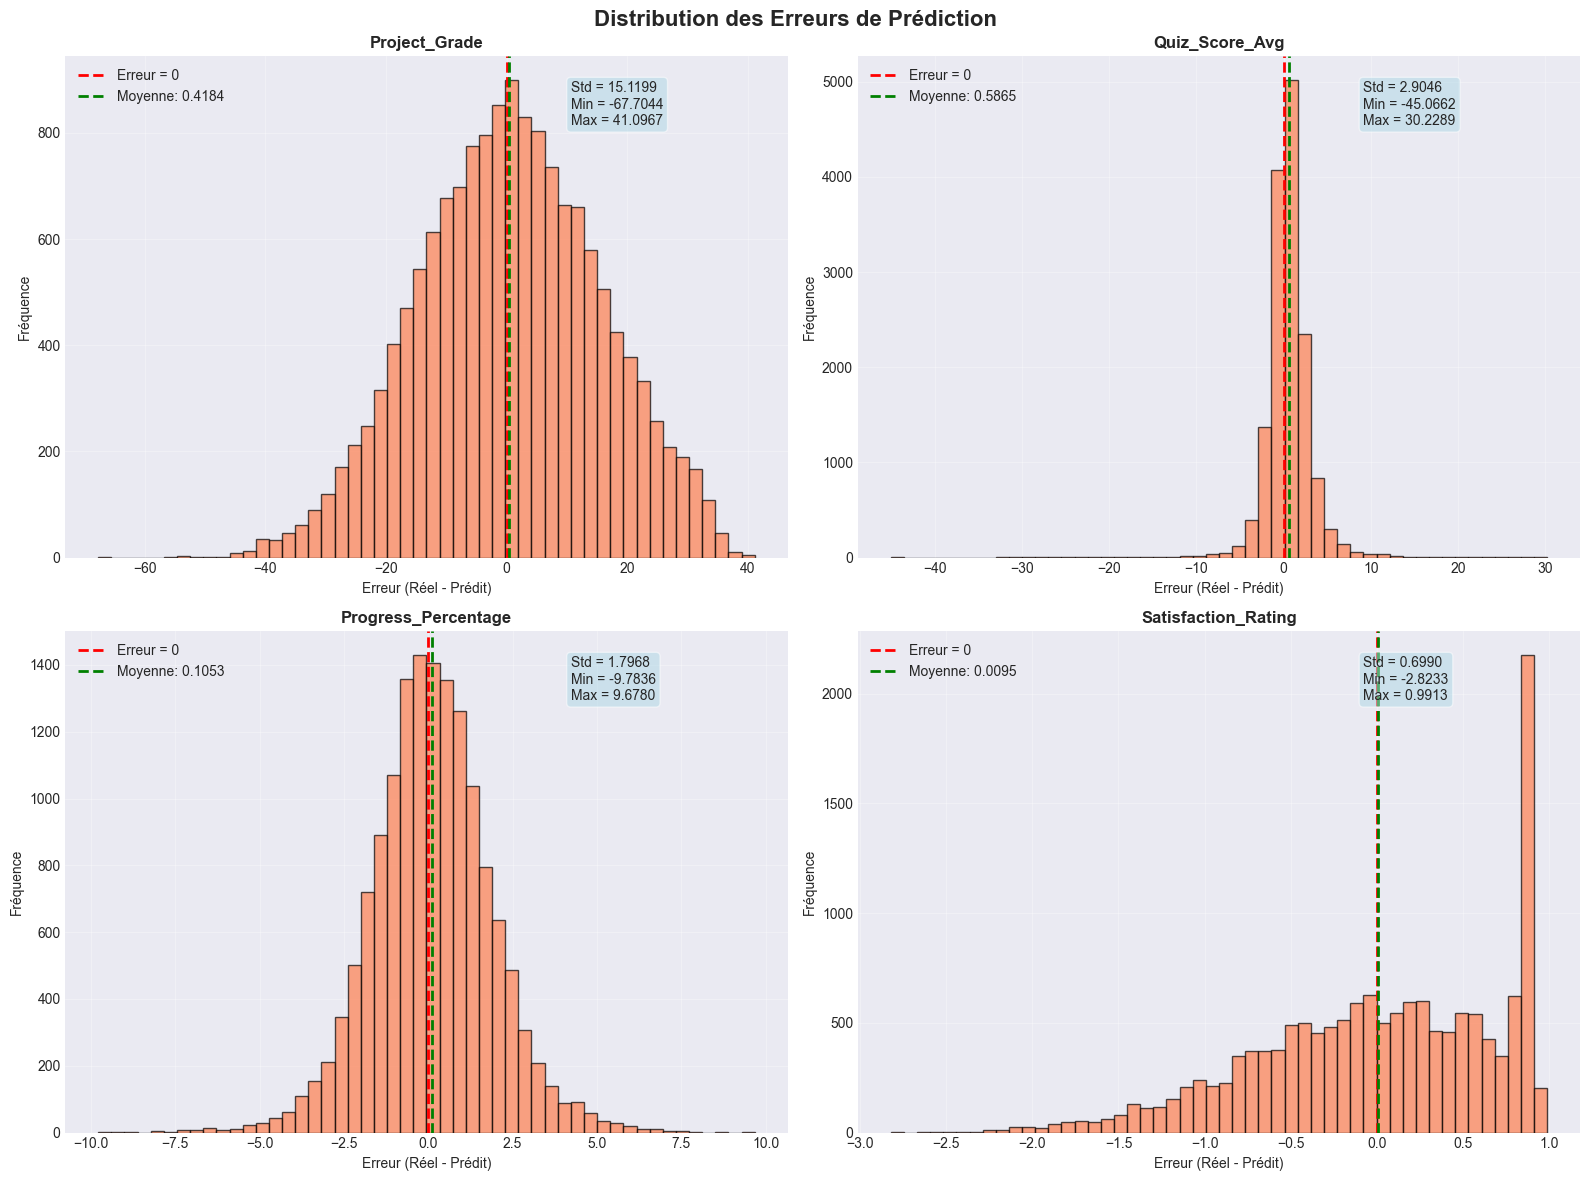

✓ Distributions d'erreurs sauvegardées : tensorflow_regression_models/error_distributions.png


In [11]:
"""Analyse des erreurs de prédiction."""

print("="*70)
print(" ANALYSE DES ERREURS")
print("="*70)

# Distribution des erreurs
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Distribution des Erreurs de Prédiction', fontsize=16, fontweight='bold')

for idx, target in enumerate(target_names):
    ax = axes[idx // 2, idx % 2]
    
    y_true = y_reg_test[:, idx]
    y_pred = y_pred_test[:, idx]
    errors = y_true - y_pred
    
    # Histogramme des erreurs
    ax.hist(errors, bins=50, alpha=0.7, edgecolor='black', color='coral')
    ax.axvline(0, color='red', linestyle='--', linewidth=2, label='Erreur = 0')
    ax.axvline(errors.mean(), color='green', linestyle='--', linewidth=2, 
               label=f'Moyenne: {errors.mean():.4f}')
    
    ax.set_title(f'{target}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Erreur (Réel - Prédit)')
    ax.set_ylabel('Fréquence')
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    # Statistiques des erreurs
    textstr = f'Std = {errors.std():.4f}\nMin = {errors.min():.4f}\nMax = {errors.max():.4f}'
    props = dict(boxstyle='round', facecolor='lightblue', alpha=0.5)
    ax.text(0.70, 0.95, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=props)

plt.tight_layout()
plt.savefig(f'{model_dir}/error_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Distributions d'erreurs sauvegardées : {model_dir}/error_distributions.png")

## 10. Sauvegarde du Modèle Final

In [12]:
"""Sauvegarde du modèle et des métriques."""

print("="*70)
print(" SAUVEGARDE DU MODÈLE")
print("="*70)

# Sauvegarde du modèle complet
model_regression.save(f'{model_dir}/final_regression_model.keras')
print(f"✓ Modèle sauvegardé : {model_dir}/final_regression_model.keras")

# Sauvegarde de l'historique
history_df = pd.DataFrame(history.history)
history_df.to_csv(f'{model_dir}/full_training_history.csv', index=False)
print(f"✓ Historique sauvegardé : {model_dir}/full_training_history.csv")

# Sauvegarde des hyperparamètres
hyperparams_final = {
    **HYPERPARAMS,
    'epochs': EPOCHS,
    'batch_size': BATCH_SIZE,
    'best_val_loss': min_val_loss,
    'best_epoch': min_epoch,
    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

with open(f'{model_dir}/hyperparameters.pkl', 'wb') as f:
    pickle.dump(hyperparams_final, f)
print(f"✓ Hyperparamètres sauvegardés : {model_dir}/hyperparameters.pkl")

# Sauvegarde des prédictions sur le test set
predictions_df = pd.DataFrame(y_pred_test, columns=target_names)
predictions_df['Set'] = 'Test'
predictions_df.to_csv(f'{model_dir}/test_predictions.csv', index=False)
print(f"✓ Prédictions sauvegardées : {model_dir}/test_predictions.csv")

print("\n" + "="*70)
print(" RÉSUMÉ")
print("="*70)
print(f"\nDossier : {model_dir}/")
print(f"\nFichiers créés :")
for file in sorted(os.listdir(model_dir)):
    file_path = os.path.join(model_dir, file)
    if os.path.isfile(file_path):
        file_size = os.path.getsize(file_path) / 1024  # KB
        print(f"  - {file:40s} ({file_size:>10.2f} KB)")

print("\n✓ Régression multi-sorties terminée avec succès !")
print("\nProchaine étape : 04_tensorflow_classification.ipynb")

 SAUVEGARDE DU MODÈLE
✓ Modèle sauvegardé : tensorflow_regression_models/final_regression_model.keras
✓ Historique sauvegardé : tensorflow_regression_models/full_training_history.csv
✓ Hyperparamètres sauvegardés : tensorflow_regression_models/hyperparameters.pkl
✓ Prédictions sauvegardées : tensorflow_regression_models/test_predictions.csv

 RÉSUMÉ

Dossier : tensorflow_regression_models/

Fichiers créés :
  - best_regression_model.keras              (    809.81 KB)
  - error_distributions.png                  (    378.28 KB)
  - final_regression_model.keras             (    809.81 KB)
  - full_training_history.csv                (     11.35 KB)
  - hyperparameters.pkl                      (      0.21 KB)
  - predictions_vs_true.png                  (   1247.50 KB)
  - test_predictions.csv                     (    635.95 KB)
  - test_results.csv                         (      0.39 KB)
  - training_curves.png                      (    204.64 KB)
  - training_history.csv                